In [1]:
import pandas as pd

# Loading

In [2]:
# Read csv
df = pd.read_csv('..\\data\\processed\\final_df.csv', parse_dates=True, index_col=0)
df.index = pd.to_datetime(df.index)
df.head(2)

,Hour,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South),Lygon St (West),IsPublicHoliday,temp,humidity,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_Spring,Season_Summer,Season_Winter
2022-04-01 00:00:00,0,166.0,24.0,380.0,73.0,215.0,48.0,0,16.90,59,...,0,0,0,0,0,0,0,1,0,0
2022-04-01 01:00:00,1,108.0,9.0,198.0,79.0,156.0,11.0,0,17.28,58,...,0,0,0,0,0,0,0,1,0,0


In [3]:
train = df[df.index < "2024-05-01"]
test = df[df.index >= "2024-05-01"]


# SARIMA

In [4]:
train.columns

Index(['Hour', 'Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'Lygon St (West)', 'IsPublicHoliday', 'temp', 'humidity', 'rain_1h',
       'clouds_all', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', 'Weekday_7', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')

## Staionary d

In [5]:
from statsmodels.tsa.stattools import adfuller

target_column = ['Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'Lygon St (West)']

for column in target_column:
    print(column)
    result = adfuller(train[column])
    print('p-value:', result[1])  # A p-value > 0.05 indicates non-stationarity.


Little Collins St-Swanston St (East)
p-value: 4.3999119450372294e-26
Faraday St-Lygon St (West)
p-value: 0.0
Melbourne Central
p-value: 1.1055394151069837e-26
Chinatown-Lt Bourke St (South)
p-value: 0.0
Lonsdale St (South)
p-value: 0.0
Lygon St (West)
p-value: 0.0


No differnecing needed

In [6]:
d = 0

## Seasonal

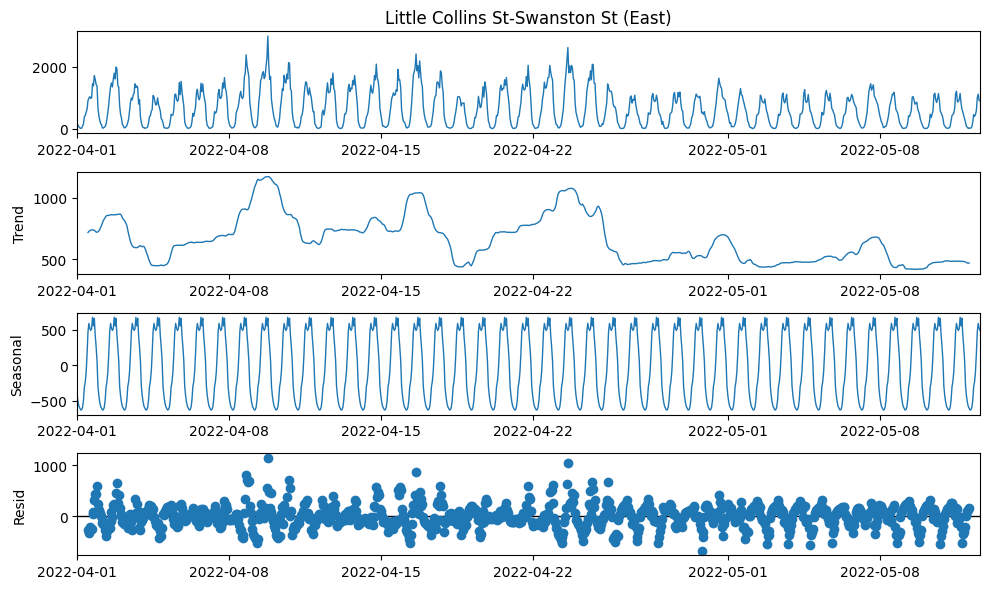

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_2 = train[:1000]

decomposition = seasonal_decompose(df_2['Little Collins St-Swanston St (East)'], model='additive', period=24)  # e.g., 24 for hourly data
fig = decomposition.plot()
# Make lines thinner
for ax in fig.axes:
    plt.setp(ax.lines, linewidth=1)

fig.set_size_inches(10, 6)  # Width x Height in inches
fig.tight_layout()  # Adjust spacing
plt.show()


In [41]:
S = 24

## Parameter

In [ ]:
from pmdarima import auto_arima

# Parallel search (no stepwise)
auto_model = auto_arima(train['Little Collins St-Swanston St (East)'],
                        seasonal=True,
                        m=24,
                        stepwise=False,  # Allow parallelization
                        n_jobs=-1,       # Use all available processors
                        start_p=0, max_p=2, 
                        start_q=0, max_q=2,
                        start_P=0, max_P=1,
                        start_Q=0, max_Q=1,
                        d=0, 
                        start_D=0, max_D=1,
                        trace=True,
                        error_action='ignore', 
                        suppress_warnings=True)

print(auto_model.summary())


In [ ]:
from pmdarima import auto_arima

# Fit auto_arima to identify best parameters
auto_model = auto_arima(train['Little Collins St-Swanston St (East)'], 
                        seasonal=True, 
                        m=24,
                        trace=True, 
                        error_action='ignore', 
                        suppress_warnings=True)
print(auto_model.summary())


Performing stepwise search to minimize aic <br>
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec<br>
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=248499.021, Time=0.33 sec<br>
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=238074.446, Time=32.03 sec<br>
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=241707.572, Time=24.58 sec<br>
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=248497.021, Time=0.24 sec<br>
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=245931.178, Time=0.76 sec<br>
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=139.20 sec<br>
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=28.42 sec<br>
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=241582.123, Time=16.48 sec<br>
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=181.84 sec<br>
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=238074.029, Time=26.19 sec<br>
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=93.51 sec<br>
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=37.30 sec<br>
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=242304.681, Time=20.03 sec<br>

 <br>
 <br>
Best: 
 ARIMA(0,1,0)(1,0,0)[24] intercept 


## Manually search

In [ ]:
import itertools
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

p = d = q = range(0, 3)
d = [0]  # We already know that d=0

P = D = Q = range(0, 1)
m = 24  # For dayly seasonality

# Generate all parameter combinations
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], m) for x in itertools.product(P, D, Q)]

best_aic = float('inf')
best_params = None
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(train['Little Collins St-Swanston St (East)'],
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
                print('New best parameters:', best_params, 'AIC:', best_aic)
        except:
            continue

print('Best SARIMAX parameters:', best_params)


In [11]:
import itertools
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm  # For progress bar

# Define parameter ranges
p = d = q = range(0, 4)
#d = [0]  # We already know that d=0
P = D = Q = range(0, 2)
m = 24  # Daily seasonality

train = train.asfreq('H')

# Generate all parameter combinations
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], m) for x in itertools.product(P, D, Q)]
total_combinations = len(pdq) * len(seasonal_pdq)

# Initialize variables to track the best model
best_aic = float('inf')
best_params = None

# Progress bar
progress_bar = tqdm(total=total_combinations, desc="Testing SARIMAX parameters")

# Grid search over all parameter combinations
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # Fit the model
            model = SARIMAX(
                train['Little Collins St-Swanston St (East)'],
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)

            # Check if the model is better
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
                print(f"New best parameters: {best_params}, AIC: {best_aic}")

        except Exception as e:
            # Handle exceptions (e.g., convergence issues) silently
            pass

        # Update the progress bar
        progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Print the best parameters
print('Best SARIMAX parameters:', best_params, 'with AIC:', best_aic)


Testing SARIMAX parameters:   0%|          | 1/512 [00:00<00:58,  8.78it/s]

New best parameters: ((0, 0, 0), (0, 0, 0, 24)), AIC: 299794.9101620198


Testing SARIMAX parameters:   0%|          | 2/512 [00:06<32:00,  3.77s/it]

New best parameters: ((0, 0, 0), (0, 0, 1, 24)), AIC: 282351.2428934265


Testing SARIMAX parameters:   1%|          | 3/512 [00:07<22:09,  2.61s/it]

New best parameters: ((0, 0, 0), (0, 1, 0, 24)), AIC: 260029.93570999076


Testing SARIMAX parameters:   1%|          | 4/512 [00:29<1:27:30, 10.34s/it]

New best parameters: ((0, 0, 0), (0, 1, 1, 24)), AIC: 255541.69070890103


Testing SARIMAX parameters:   2%|▏         | 8/512 [01:30<2:39:16, 18.96s/it]

New best parameters: ((0, 0, 0), (1, 1, 1, 24)), AIC: 253469.72419527202


Testing SARIMAX parameters:   2%|▏         | 11/512 [01:47<1:24:06, 10.07s/it]

New best parameters: ((0, 0, 1), (0, 1, 0, 24)), AIC: 248355.83160703577


Testing SARIMAX parameters:   2%|▏         | 12/512 [02:27<2:40:32, 19.26s/it]

New best parameters: ((0, 0, 1), (0, 1, 1, 24)), AIC: 242225.79417406046


Testing SARIMAX parameters:   3%|▎         | 13/512 [02:35<2:11:17, 15.79s/it]c:\Users\Biebert\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Testing SARIMAX parameters:   3%|▎         | 15/512 [03:40<3:14:28, 23.48s/it]

KeyboardInterrupt: 

Best SARIMAX parameters: ((2, 0, 1), (0, 0, 0, 24)) with AIC: 244806.5889018608


## Fit SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMAX model with identified parameters
sarimax_model = SARIMAX(train['Little Collins St-Swanston St (East)'],
                        order=(p, d, q),              # Replace with values from auto_arima
                        seasonal_order=(P, D, Q, m),  # Replace with values from auto_arima
                        enforce_stationarity=False,
                        enforce_invertibility=False)

# Fit the model
sarimax_results = sarimax_model.fit()
print(sarimax_results.summary())


### Make it multiv.

In [ ]:
# Model without exog
sarimax_no_exog = SARIMAX(train['Little Collins St-Swanston St (East)'],
                          order=(p, d, q),
                          seasonal_order=(P, D, Q, m),
                          enforce_stationarity=False,
                          enforce_invertibility=False).fit()

# Model with exog
sarimax_with_exog = SARIMAX(df['Little Collins St-Swanston St (East)'],
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, m),
                            exog=train[['temp', 'humidity']],
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit()

print("AIC Without Exog:", sarimax_no_exog.aic)
print("AIC With Exog:", sarimax_with_exog.aic)


Use mroe other variabels and see what happens

Maybe use this to select it:

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

X = train[['temp', 'humidity', 'clouds_all']]
y = train['Little Collins St-Swanston St (East)']
selector = SelectKBest(f_regression, k=2)  # Select top 2 features
X_new = selector.fit_transform(X, y)
print(X.columns[selector.get_support()])


#### Automate it

In [ ]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

p = 
d =
q =

P =
D =
Q =
m = 24

# Define potential exog variables
potential_exog = ['temp', 'humidity', 'clouds_all']

# Iterate over all combinations of exog variables
best_aic = float('inf')
best_exog = None
for L in range(1, len(potential_exog) + 1):
    for subset in itertools.combinations(potential_exog, L):
        try:
            model = SARIMAX(df['target_variable'],
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, m),
                            exog=df[list(subset)],
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_exog = subset
        except:
            continue

print("Best AIC:", best_aic)
print("Best Exog Variables:", best_exog)


## Check for Resid

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data['target_column'],
                order=(1, 1, 0),
                seasonal_order=(1, 0, 0, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(15, 8))


In [ ]:
import matplotlib.pyplot as plt

# Residuals from the fitted model
residuals = sarimax_results.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.axhline(0, linestyle='--', color='r', alpha=0.7)
plt.show()


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()

# PACF plot
plot_pacf(residuals, lags=40)
plt.title('PACF of Residuals')
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test
ljung_box = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print(ljung_box)


# GARCH

# Try TBATS 

https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a